# Implementation

> Here we'll be following Keras' example: https://keras.io/examples/generative/pixelcnn/

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-08-08 23:56:26.086253: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 23:56:26.142007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 23:56:27.875833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
from typing import Any, Callable, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce
import wandb

## Data

We'll be using the MNIST dataset in order to simplify the problem.

In [3]:
from tensorflow.keras.datasets import mnist

In [1]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In their example they binarize the images. We'll follow along but I don't know why are they doing this yet. 

In [2]:
X_train_bin = jnp.where(X_train < (0.33)*256, 0., 1.)
X_test_bin = jnp.where(X_test < (0.33)*256, 0., 1.)

# X_train_bin = X_train_bin.astype(jnp.float32)
# X_test_bin = X_test_bin.astype(jnp.float32)

jnp.unique(X_train_bin)

Array([0., 1.], dtype=float32, weak_type=True)

In [6]:
dst_train = tf.data.Dataset.from_tensor_slices(X_train_bin)
dst_val = tf.data.Dataset.from_tensor_slices(X_test_bin)

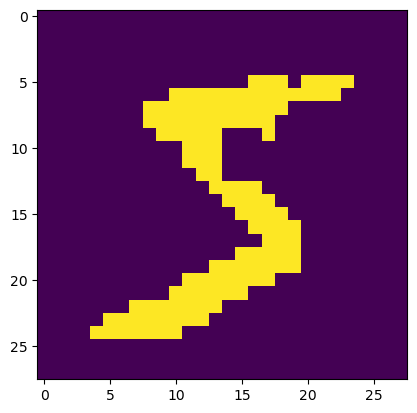

In [7]:
img = next(iter(dst_train))
plt.imshow(img)
plt.show()

In [8]:
dst_train_rdy = dst_train.batch(64)
dst_val_rdy = dst_val.batch(64)

## Model blocks

One of the key components of the model is their masking. They do this so that the model doesn't see the future pixels to predict a specific pixel.

The idea is to generate a mask like the following:

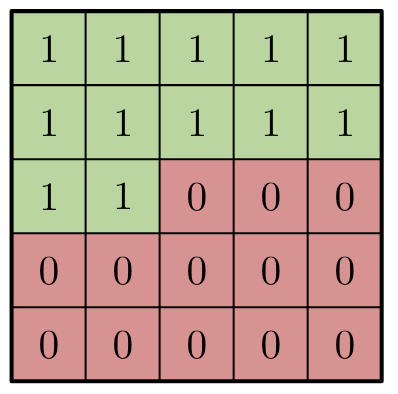

They have a different kind of mask where the central pixel is also a 1. so that it can be connected to itself.

In [9]:
class PixelConv(nn.Module):
    """Masked convolution as in PixelCNN."""
    mask_type: str
    features: int
    kernel_size: Sequence[int]
    strides: int = 1
    padding: str = "SAME"
    use_bias: bool = True
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self, inputs):
        ## 0. Instantiate the kernel and bias of the convolution
        kernel = self.param("kernel",
                            self.kernel_init,
                            (self.kernel_size[0], self.kernel_size[1], inputs.shape[-1], self.features))
        bias = self.param("bias",
                          self.bias_init,
                          (self.features,)) if self.use_bias else 0.

        ## 1. Build the mask
        mask = self.generate_mask(kernel.shape, self.mask_type)

        ## 2. Calculate the masked convolution
        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel*mask,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias
    
    @staticmethod
    def generate_mask(kernel_size, mask_type):
        mask = jnp.zeros(shape=kernel_size)
        mask = mask.at[:kernel_size[0]//2].set(1.)
        mask = mask.at[kernel_size[0]//2,:kernel_size[1]//2].set(1.)
        if mask_type == "B":
            mask = mask.at[kernel_size[0]//2,kernel_size[1]//2].set(1.)
        return mask

We can initialize the parameters of the layer to see if everything works as intended:

In [3]:
l = PixelConv(mask_type="B", features=1, kernel_size=(5,5))
key = random.PRNGKey(0)
params = l.init(key, jnp.ones((1,28,28,1)))
jax.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        bias: (1,),
        kernel: (5, 5, 1, 1),
    },
})

And as a sanity check we can as well check that the `.generate_mask()` method behaves as intended for both cases:

In [4]:
l = PixelConv(mask_type="A", features=1, kernel_size=(5,5))
l.generate_mask(kernel_size=(5,5), mask_type="A")

Array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [5]:
l = PixelConv(mask_type="B", features=1, kernel_size=(5,5))
l.generate_mask(kernel_size=(5,5), mask_type="B")

Array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

They also define a residual block based on this masked convolution, so we'll follow along:

In [13]:
class ResidualBlock(nn.Module):
    """Residual block based on the `PixelConv` layer."""
    mask_type: str
    features: int
    kernel_size: Sequence[int]
    strides: int = 1
    padding: str = "SAME"
    use_bias: bool = True
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self, inputs):
        outputs = nn.Conv(self.features, kernel_size=(1,1))(inputs)
        outputs = nn.relu(outputs)
        outputs = PixelConv(features=self.features//2, kernel_size=self.kernel_size, mask_type=self.mask_type)(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.Conv(self.features, kernel_size=(1,1))(outputs)
        outputs = nn.relu(outputs)
        return inputs + outputs

In [6]:
l = ResidualBlock(mask_type="B", features=2, kernel_size=(5,5))
key = random.PRNGKey(0)
params = l.init(key, jnp.ones((1,28,28,1)))
jax.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        Conv_0: {
            bias: (2,),
            kernel: (1, 1, 1, 2),
        },
        Conv_1: {
            bias: (2,),
            kernel: (1, 1, 1, 2),
        },
        PixelConv_0: {
            bias: (1,),
            kernel: (5, 5, 2, 1),
        },
    },
})

## Building the original model

In [15]:
class PixelCNN(nn.Module):
    """PixelCNN model as stated in their original paper (or so they said in the Keras example)."""

    n_residual_blocks: int = 5

    @nn.compact
    def __call__(self, inputs):
        outputs = PixelConv(features=128, kernel_size=(7,7), mask_type="A")(inputs)
        outputs = nn.relu(outputs)
        for _ in range(self.n_residual_blocks):
            outputs = ResidualBlock(features=128, kernel_size=(3,3), mask_type="B")(outputs)
            outputs = nn.relu(outputs)
        outputs = PixelConv(features=128, kernel_size=(1,1), mask_type="B")(outputs)
        outputs = nn.relu(outputs)
        outputs = PixelConv(features=128, kernel_size=(1,1), mask_type="B")(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.Conv(features=1, kernel_size=(1,1))(outputs)
        ## Skip the sigmoid activation because it's included in the loss function we will be using
        return outputs

## Preparations before training

> Things like building the `TrainState` and so.

In [16]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

In [17]:
class TrainState(train_state.TrainState):
    metrics: Metrics

In [18]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    params = module.init(key, jnp.ones(input_shape))["params"]
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty()
    )

### Training step

In [19]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    inputs = batch
    def loss_fn(params):
        pred = state.apply_fn({"params": params}, inputs)
        loss = optax.sigmoid_binary_cross_entropy(logits=pred, labels=inputs).mean()
        return loss, pred
    (loss, pred), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    def compute_metrics(state):
        metric_updates = state.metrics.single_from_model_output(
            logits=pred, labels=inputs, loss=loss,
        )
        metrics = state.metrics.merge(metric_updates)
        state = state.replace(metrics=metrics)
        return state
    state = compute_metrics(state)
    return state

In [20]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    inputs = batch
    pred = state.apply_fn({"params": state.params}, inputs)
    loss = optax.sigmoid_binary_cross_entropy(logits=pred, labels=inputs).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=pred, labels=inputs, loss=loss,
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [21]:
state = create_train_state(PixelCNN(), random.PRNGKey(0), optax.adam(3e-4), input_shape=(1,28,28,1))

In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [22]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [23]:
EPOCHS = 1000

In [24]:
%%time
for epoch in range(EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    # wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} | [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

Epoch 0 -> [Train] Loss: 0.10738322883844376 | [Val] Loss: 0.0964701697230339
Epoch 1 -> [Train] Loss: 0.09107647091150284 | [Val] Loss: 0.09731429815292358
Epoch 2 -> [Train] Loss: 0.08957286179065704 | [Val] Loss: 0.10225003212690353
Epoch 3 -> [Train] Loss: 0.08864208310842514 | [Val] Loss: 0.09415137022733688
Epoch 4 -> [Train] Loss: 0.08789239078760147 | [Val] Loss: 0.09250602126121521
Epoch 5 -> [Train] Loss: 0.08720973879098892 | [Val] Loss: 0.09165811538696289
Epoch 6 -> [Train] Loss: 0.08665670454502106 | [Val] Loss: 0.08975152671337128
Epoch 7 -> [Train] Loss: 0.08617578446865082 | [Val] Loss: 0.08826755732297897
Epoch 8 -> [Train] Loss: 0.0857725515961647 | [Val] Loss: 0.08740673214197159
Epoch 9 -> [Train] Loss: 0.08542186766862869 | [Val] Loss: 0.08710061013698578
Epoch 10 -> [Train] Loss: 0.0851156935095787 | [Val] Loss: 0.08661967515945435
Epoch 11 -> [Train] Loss: 0.08483607321977615 | [Val] Loss: 0.0863041803240776
Epoch 12 -> [Train] Loss: 0.08458948880434036 | [Val] 

In [ ]:
orbax_checkpointer.save(f"model-final-{EPOCHS}", state, save_args=save_args, force=True) # force=True means allow overwritting.

## Generating an image

PixelCNN is an autorregresive model, so in order to generate a full image we have to generate it one pixel at a time. Good thing is we should be able to `jit` this operation to make it faster!

In [ ]:
@jax.jit
def obtain_pred(state, inputs): 
    return state.apply_fn({"params": state.params}, inputs)

In [42]:
%%time
keygen = random.PRNGKey(0)
n_imgs_to_generate = 4
generated_batch = jnp.zeros(shape=(n_imgs_to_generate,28,28,1))
batch, rows, cols, channels = generated_batch.shape

for row in range(rows):
    for col in range(cols):
        for channel in range(channels):
            ## 1. Pass the blank images to generate the next (or first) pixel
            pred = obtain_pred(state, generated_batch)
            pred = nn.sigmoid(pred)
            ## 2. Obtain the value of the pixel by sampling from a Bernoulli distribution
            pixel = pred[:,row,col,channel]
            pixel = random.bernoulli(keygen, p=pixel)*1.
            keygen, _ = random.split(keygen)
            generated_batch = generated_batch.at[:,row,col,channel].set(pixel)

CPU times: user 2min 56s, sys: 13.6 s, total: 3min 10s
Wall time: 2min 45s


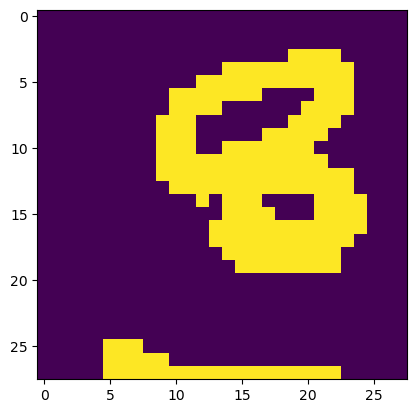

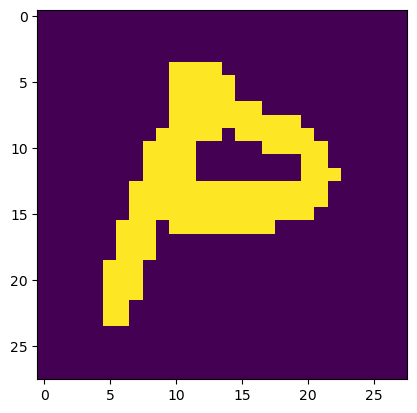

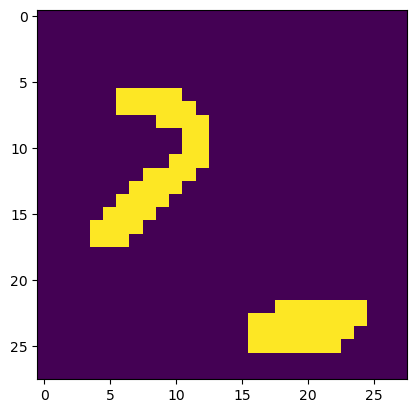

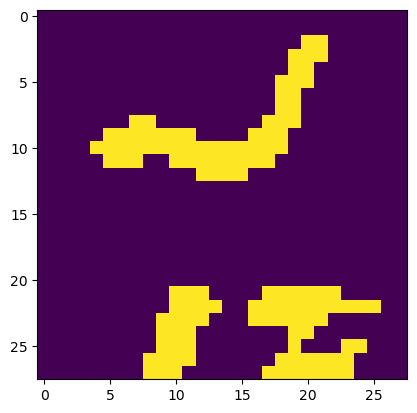

In [43]:
for gen_img in generated_batch:
    plt.imshow(gen_img)
    plt.show()

In [27]:
# @jax.jit
# def generate_image():
#     n_imgs_to_generate = 1
#     generated_batch = jnp.zeros(shape=(n_imgs_to_generate,28,28,1))
#     batch, rows, cols, channels = generated_batch.shape

#     for row in range(rows):
#         for col in range(cols):
#             for channel in range(channels):
#                 ## 1. Pass the blank images to generate the next (or first) pixel
#                 pred = state.apply_fn({"params": state.params}, generated_batch)
#                 pred = nn.sigmoid(pred)
#                 ## 2. Choose the value of the corresponding pixel according to its probability
#                 pixel = (pred[:,row,col,channel] > 0.5)*1.
#                 generated_batch = generated_batch.at[:,row,col,channel].set(pixel)
#     return generated_batch

In [28]:
# %%time
# generated_batch = generate_image()

In [29]:
# for gen_img in generated_batch:
#     plt.imshow(gen_img)
#     plt.show()